# Import Statements

In [1]:
# Import statements for data Manipulation and analysis
import pandas as pd
import numpy as np

# Used for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Used for the Machine Learning - Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, median_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

# Database Interaction
from sqlalchemy import create_engine
from urllib.parse import quote_plus

import csv
import os
import psycopg2


# Transfer the Data to Postgresql

#### Let's Start by storing our data from the csv file in a dataframe
#### After inspecting the data I notice that the columns are seperated with a ';' semi colon, so I seperate them using the delimiter. 
#### To get a look at the dataframe and make sure the data is as we expect, I created a print statements will give us a glimpse of the code structure and a brief summary about each columns statistics.

In [2]:
df = pd.read_csv("./docs/data.csv", delimiter=';')
print(df.head(10))  # Display first few rows
print(df.describe())  # Display summary statistics

  school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0     GP   F   16       U     LE3       T     4     3   teacher  services   
1     GP   M   18       U     LE3       T     1     1     other     other   
2     GP   M   17       R     LE3       A     4     4   teacher     other   
3     GP   F   15       U     LE3       T     3     2  services     other   
4     GP   M   16       U     GT3       T     2     3     other     other   
5     GP   F   17       U     LE3       T     3     3     other     other   
6     MS   F   17       R     GT3       T     1     2     other     other   
7     GP   F   16       R     GT3       T     4     4    health   teacher   
8     GP   F   17       R     GT3       T     3     4   at_home  services   
9     GP   F   16       U     GT3       T     2     3  services   teacher   

   ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0  ...      5        4      3     1     2      1        2  16  15  15  
1  ...  

### Below we will have two functions that will do the following:
1. The first function (load_data_to_postgres_docker) will load the data from the csv file into the database
2. The second function (add_new_student) will add a new student row with information provided to the postgres database.

In [3]:
def load_data_to_postgres_docker(table_name, user, password, host='127.0.0.1', port=5432, database_name='student_grades'):
    # Create engine with SQLAlchemy
    password = quote_plus(password)
    engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database_name}')

    # Transfer data to database
    df.to_sql(table_name, engine, index=False, if_exists='replace')

load_data_to_postgres_docker('student_grades_table', 'leonphoenix21', 'vtlt123@dck')


In [4]:
def add_new_student(student_info, table_name, database_name, user, password, host='127.0.0.1', port=5432):
    # Create engine with SQLAlchemy
    password = quote_plus(password)
    engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database_name}')

    # Convert student_info to DataFrame
    new_student_data = pd.DataFrame([student_info])

    # Append new student data to the PostgreSQL table
    new_student_data.to_sql(table_name, engine, index=False, if_exists='append')

new_student_info = {
    'school': 'GP',
    'sex': 'M',
    'age': 16,
    'address': 'U',
    'famsize': 'LE3',
    'Pstatus': 'T',
    'Medu': 4,
    'Fedu': 3,
    'Mjob': 'teacher',
    'Fjob': 'services',
    'reason': 'course',
    'guardian': 'mother',
    'traveltime': 3,
    'studytime': 2,
    'failures': 0,
    'schoolsup': 'no',
    'famsup': 'yes',
    'paid': 'no',
    'activities': 'yes',
    'nursery': 'yes',
    'higher': 'yes',
    'internet': 'yes',
    'romantic': 'no',
    'famrel': 5,
    'freetime': 4,
    'goout': 3,
    'Dalc': 1,
    'Walc': 2,
    'health': 1,
    'absences': 2,
    'G1': 15,
    'G2': 14,
    'G3': 15
}

# add_new_student(new_student_info, 'student_grades_table', 'student_grades', 'leonphoenix21', 'vtlt123@dck')

#### Now we are going to Clean, process and explore the data, by calculating the frequencies and mutual information score for each feature as well creating visualizations that will give an insight into the correlation between features. Allowing us to analyze and better understand the relationship of the features to the target feature.
#### The Code Blocks below should accomplish the following tasks:
+ Handle missing values 
* We will check for any inconsistent data entry any duplicates e.t.c
<br>

### Handle missing values.
#### First Section here checks for the missing values and then we print all the columns and the number of missing values since we have a smaller database. 

In [5]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64
0.0


#### Check for duplicated rows
Now we move on to checking for duplicate rows in our dataframe and drop them if any

In [6]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()
print(df)

False    316
Name: count, dtype: int64
    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   16       U     LE3       T     4     3   teacher  services   
1       GP   M   18       U     LE3       T     1     1     other     other   
2       GP   M   17       R     LE3       A     4     4   teacher     other   
3       GP   F   15       U     LE3       T     3     2  services     other   
4       GP   M   16       U     GT3       T     2     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
311     GP   M   15       U     LE3       A     2     1  services     other   
312     GP   F   17       U     GT3       A     4     4     other   teacher   
313     GP   F   15       U     GT3       T     4     4   teacher   teacher   
314     MS   F   19       R     GT3       T     2     3  services     other   
315     GP   M   16       U     LE3       T     4     3   teacher  services   

     ... fam

# Feature Selection 

Now we are about to Train our model. First in the code block below I create a copy of the data without the G3 column and we then clone the G3 column in the y-variable so that we can compare our predictions to the actual results from our target variable

In [7]:
X = df.drop("G3", axis = 1)
print(X.describe())
y = df["G3"]

print(X.shape)
print(y.shape)

              age        Medu        Fedu  traveltime   studytime    failures  \
count  316.000000  316.000000  316.000000  316.000000  316.000000  316.000000   
mean    16.693038    2.768987    2.525316    1.443038    2.085443    0.306962   
std      1.310791    1.104301    1.070228    0.708172    0.848328    0.724239   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
50%     17.000000    3.000000    3.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  316.000000  316.000000  316.000000  316.000000  316.000000  316.000000   
mean     3.924051    3.243671    3.145570    1.474684    2.300633    3.496835   
std      0.908823    0.9697

So Here I am defining my categorical columns and I am going to encode those columns using a label encoder. I am making a note to encode the X variables and not the main (df) dataframe variables.

In [8]:
categorical_columns = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'
]

# Here I am applying label encoding to categorical columns in X
label_encoder = LabelEncoder()
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

print(X.head(1))

   school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0       0    0   16        1        1        1     4     3     4     3  ...   

   romantic  famrel  freetime  goout  Dalc  Walc  health  absences  G1  G2  
0         0       5         4      3     1     2       1         2  16  15  

[1 rows x 32 columns]


Below I plan to create visualizations that will help us with our feature selection by seeing the correlation between the features, the spread of each feature and the their shape.

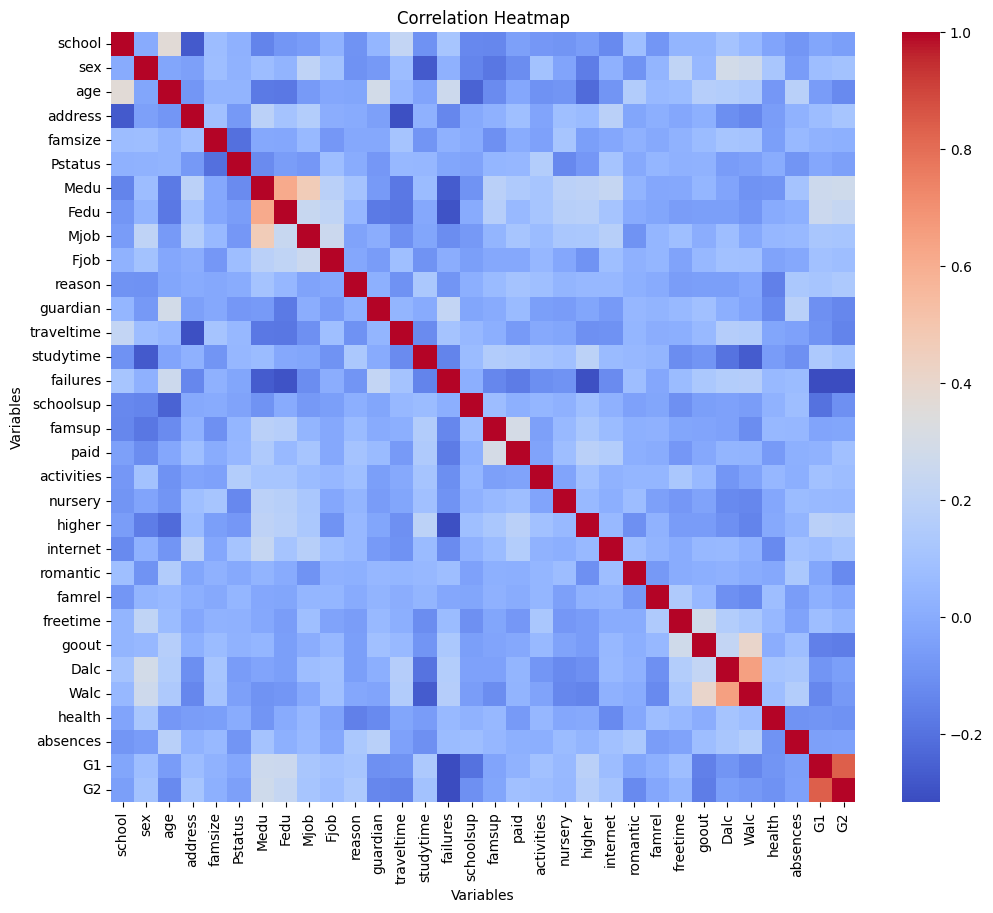

In [9]:
EDA_df = X.copy()

corr_matrix = EDA_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,  cmap='coolwarm', annot_kws={"size": 5})
plt.title("Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

array([[<Axes: title={'center': 'school'}>,
        <Axes: title={'center': 'sex'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'address'}>,
        <Axes: title={'center': 'famsize'}>,
        <Axes: title={'center': 'Pstatus'}>],
       [<Axes: title={'center': 'Medu'}>,
        <Axes: title={'center': 'Fedu'}>,
        <Axes: title={'center': 'Mjob'}>,
        <Axes: title={'center': 'Fjob'}>,
        <Axes: title={'center': 'reason'}>,
        <Axes: title={'center': 'guardian'}>],
       [<Axes: title={'center': 'traveltime'}>,
        <Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'failures'}>,
        <Axes: title={'center': 'schoolsup'}>,
        <Axes: title={'center': 'famsup'}>,
        <Axes: title={'center': 'paid'}>],
       [<Axes: title={'center': 'activities'}>,
        <Axes: title={'center': 'nursery'}>,
        <Axes: title={'center': 'higher'}>,
        <Axes: title={'center': 'internet'}>,
        <Axes: title={'center

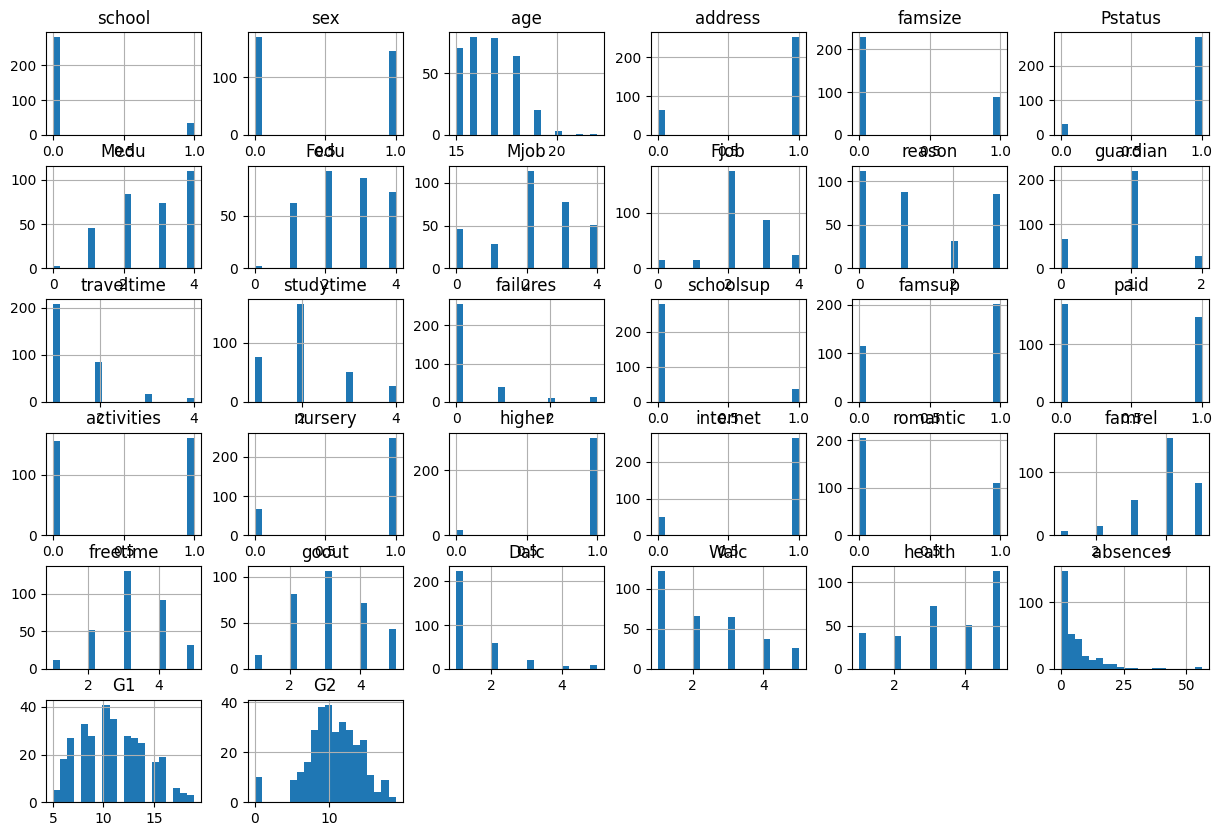

In [10]:
X.hist(bins=20, figsize=(15, 10))

After looking through the visualizations and exploring the data, I took a note of the performance of all the features and decided to create 10 new features as well as 10 feature subsets to evaluate and find the best performing model.

In [11]:
# Creating new features here to see if they will improve the model
X['academic_performance'] = X['G1'] + X['G2']
X['study_engagement'] = X['studytime'] * X['absences']
X['social_life'] = X['goout'] * X['freetime']
X['family_support'] = X['famsup'] * X['famrel']
X['health_and_activities'] = X['health'] * X['activities']
X['alcohol_consumption'] = X['Dalc'] + X['Walc']
X['study_habits'] = X['studytime'] * X['failures']
X['parental_education'] = X['Medu'] + X['Fedu']
X['internet_higher_edu'] = X['internet'] * X['higher']
X['Walc_health'] = X['Walc'] * X['health']



# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int


Now that we have created new features we can calculate our mutual information score and create a visualization for each feature to find the best performing features to use that information for creating our featuresets

In [12]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)

G2                       1.410783
academic_performance     1.200656
G1                       0.810519
absences                 0.154330
failures                 0.125630
study_engagement         0.125171
study_habits             0.083608
Mjob                     0.075704
paid                     0.066850
alcohol_consumption      0.058967
Walc                     0.054872
romantic                 0.045631
Medu                     0.044145
age                      0.041751
schoolsup                0.035001
Dalc                     0.034849
reason                   0.029369
Fjob                     0.028967
higher                   0.026669
guardian                 0.026173
Walc_health              0.025491
health                   0.022203
studytime                0.016730
sex                      0.014022
school                   0.012836
famsize                  0.006285
internet_higher_edu      0.005707
Fedu                     0.003086
freetime                 0.002457
goout         

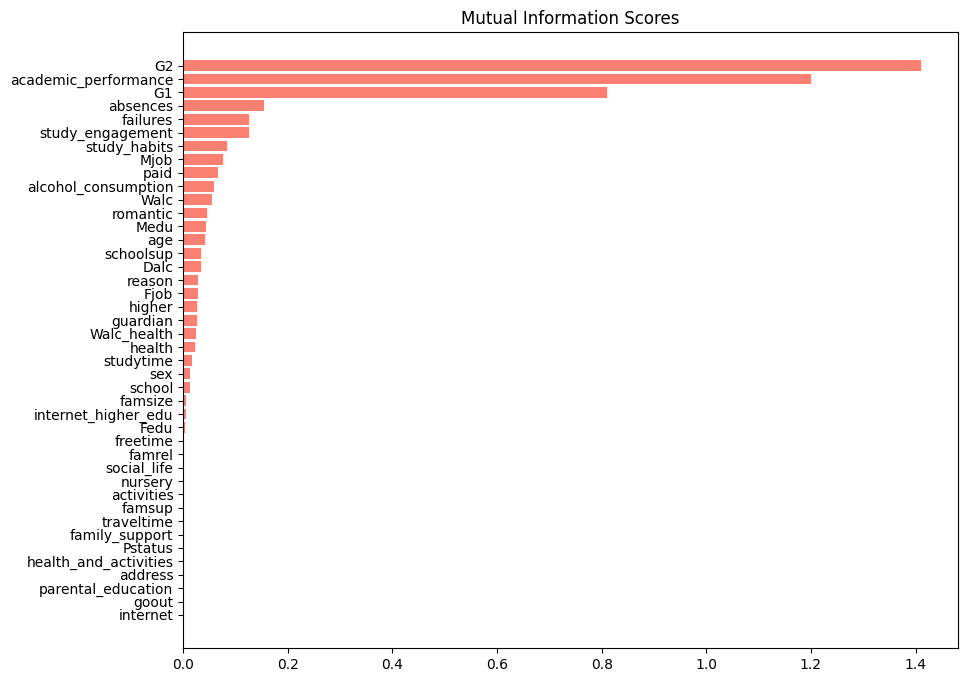

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color='salmon')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(figsize=(10, 8))
plot_mi_scores(mi_scores)
plt.show()

After taking a look at the MI scores it's apparent that only a few features are highly dependent on our target variable (G3). So using that information we can now create an array of feature sets to test against our model. I chose to use the high performing features first and then to add more features to test which one works best.

In [14]:
# Create a list of subsets to evaluate
featureSets = [
  ['G2', 'academic_performance', 'G1', 'study_engagement'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'romantic'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption', 'paid'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption', 'paid', 'schoolsup']
]

# Model Training 

Now that we have created new features and tested the performance and selected our features for our featureset. We will now be training our data using 3 different models to see which model will perform best with our features.


In [15]:

results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2', 'MSE', 'mean_absolute_percentage', 'max_error', 'median_absolute_error'])

for features in featureSets:
    try:
        X_features = X[features]
        print(X_features.head(1))

        # Scale features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Define models
        models = {
            'KNN Regressor': KNeighborsRegressor(),
            'Linear SVR': SVR(),
            'Ridge Regressor': Ridge()
        }

        # Train and evaluate models
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mean_absolute_percentage = mean_absolute_error(y_test, y_pred)
            max_err = max_error(y_test, y_pred)
            medianae = median_absolute_error(y_test, y_pred)

            results_df.loc[len(results_df.index)] = [', '.join(features), model_name, r2, mse, mean_absolute_percentage, max_err, medianae]

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(results_df)

   G2  academic_performance  G1  study_engagement
0  15                    31  16                 4
   G2  academic_performance  G1  study_engagement  failures  romantic
0  15                    31  16                 4         0         0
   G2  academic_performance  G1  study_engagement  failures
0  15                    31  16                 4         0
   G2  academic_performance  G1  study_engagement  failures  Mjob
0  15                    31  16                 4         0     4
   G2  academic_performance  G1  study_engagement  failures  Mjob  Walc
0  15                    31  16                 4         0     4     2
   G2  academic_performance  G1  study_engagement  failures  Mjob  Walc  Fjob
0  15                    31  16                 4         0     4     2     3
   G2  academic_performance  G1  study_engagement  failures  Mjob  Walc  Fjob  \
0  15                    31  16                 4         0     4     2     3   

   sex  
0    0  
   G2  academic_performance

Now that we have trained our models on our feature sets lets create some visualizations displaying the model performance by measuring different important metrics that tell us how accurate our predictions are. We can gain insights from this process to understand how we can fine-tune the model for enhanced performance.

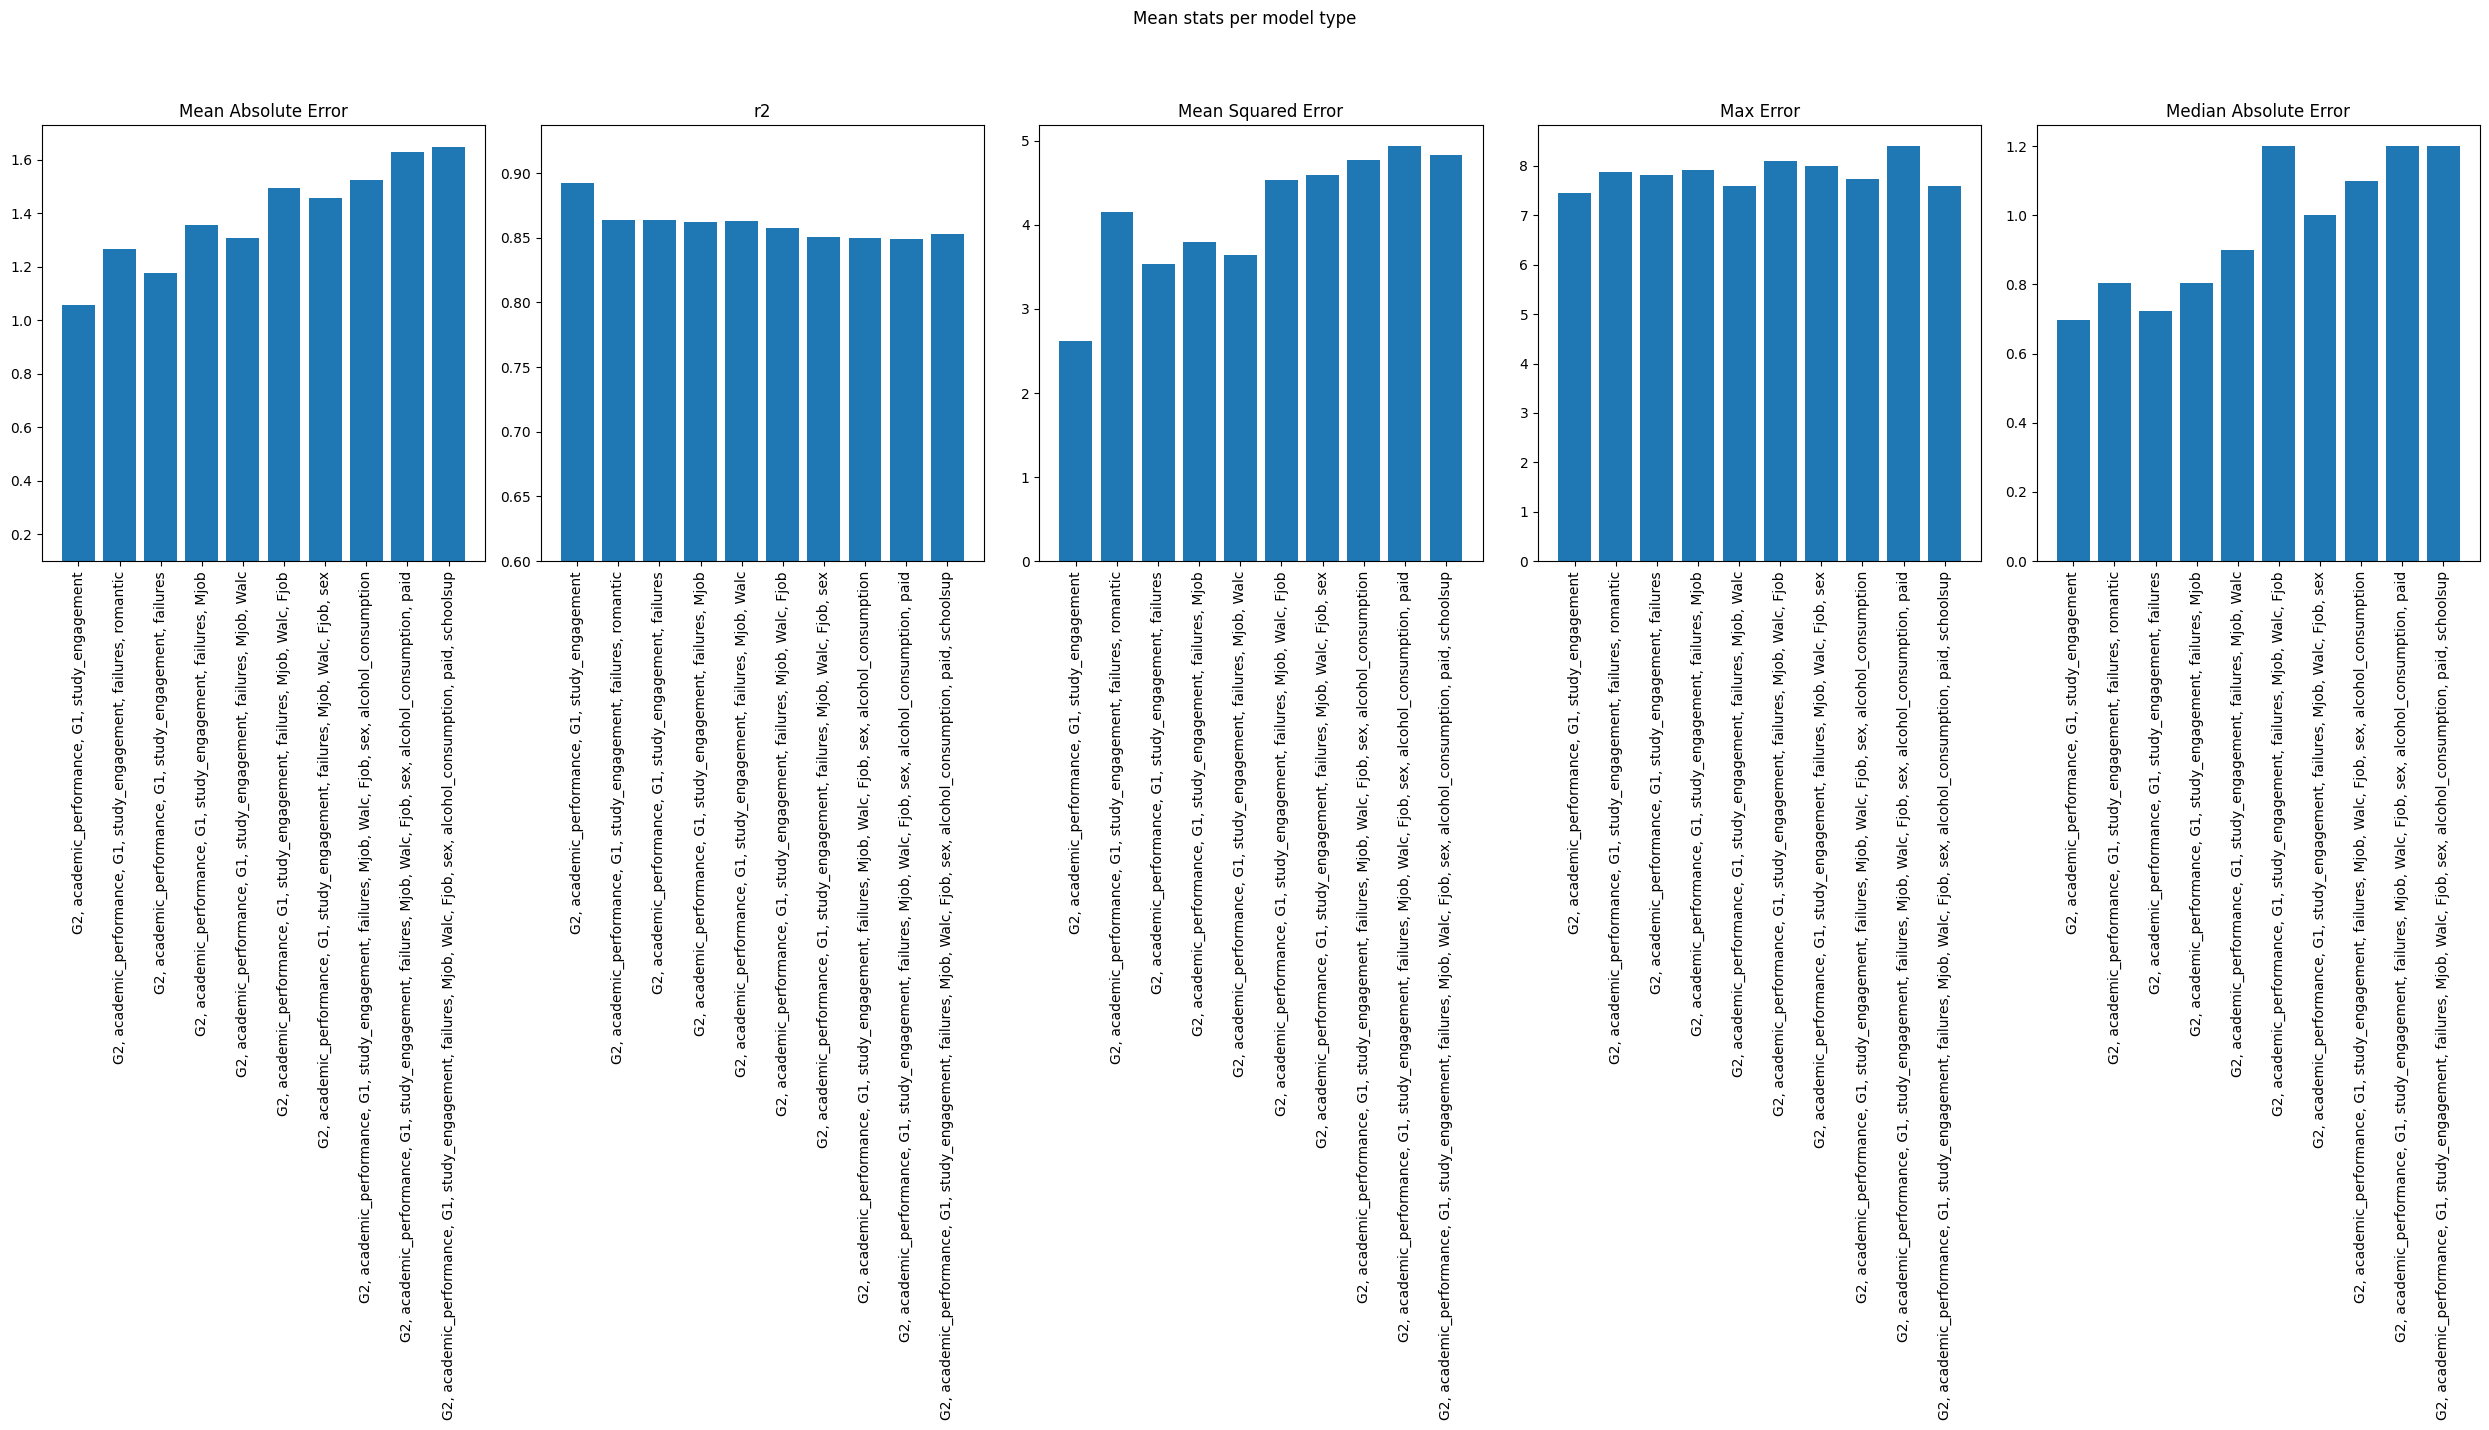

In [16]:
# Create a figure with subplots
plt.figure(figsize=(25,15))
plt.suptitle("Mean stats per model type")

# Subplot 1: Mean Absolute Error
plt.subplot(1, 5, 1)
plt.bar(results_df['Feature Set'], results_df['mean_absolute_percentage'])
plt.ylim(0.1)
plt.title("Mean Absolute Error")
plt.xticks(rotation='vertical')

# Subplot 2: r2
plt.subplot(1, 5, 2)
plt.bar(results_df['Feature Set'], results_df['r2'])
plt.ylim(0.6)
plt.title("r2")
plt.xticks(rotation='vertical')

# Subplot 3: Mean Squared Error
plt.subplot(1, 5, 3)
plt.bar(results_df['Feature Set'], results_df['MSE'])
plt.title("Mean Squared Error")
plt.xticks(rotation='vertical')

# Subplot 4: Max Error
plt.subplot(1, 5, 4)
plt.bar(results_df['Feature Set'], results_df['max_error'])
plt.title("Max Error")
plt.xticks(rotation='vertical')

# Subplot 5: Median Absolute Error
plt.subplot(1, 5, 5)
plt.bar(results_df['Feature Set'], results_df['median_absolute_error'])
plt.title("Median Absolute Error")
plt.xticks(rotation='vertical')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


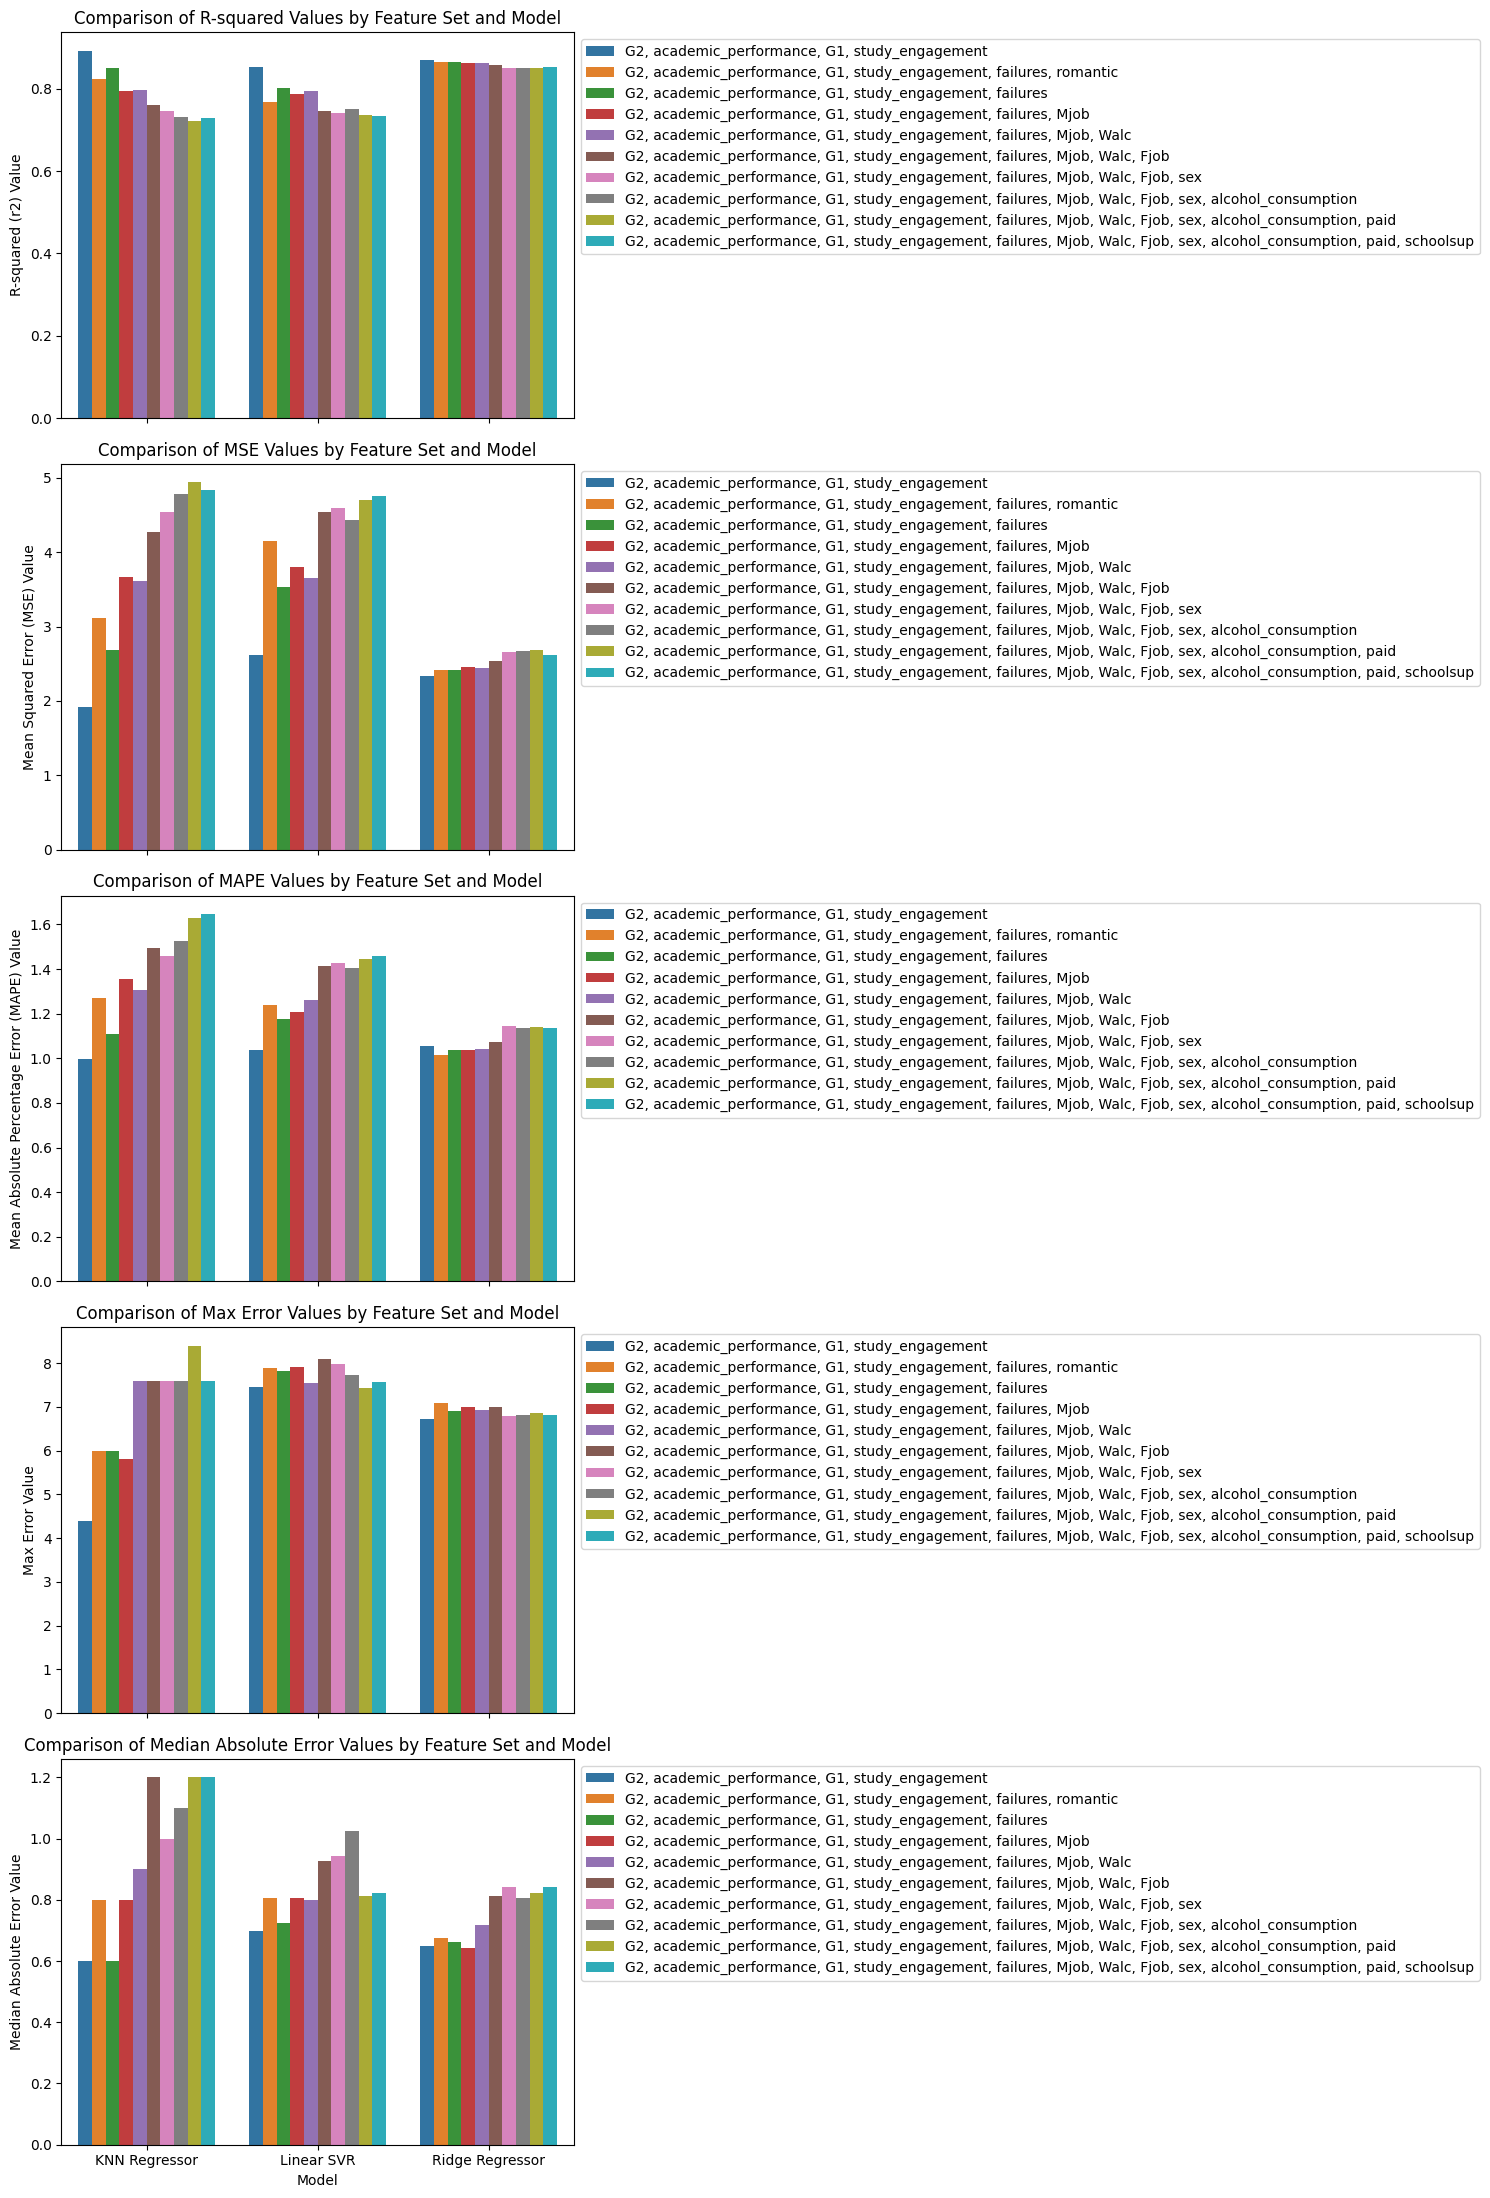

In [17]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 24), sharex=True)

# Bar plot for R-squared (r2)
sns.barplot(x='Model', y='r2', hue='Feature Set', data=results_df, ax=axes[0])
axes[0].set_ylabel('R-squared (r2) Value')
axes[0].set_title('Comparison of R-squared Values by Feature Set and Model')

# Bar plot for Mean Squared Error (MSE)
sns.barplot(x='Model', y='MSE', hue='Feature Set', data=results_df, ax=axes[1])
axes[1].set_ylabel('Mean Squared Error (MSE) Value')
axes[1].set_title('Comparison of MSE Values by Feature Set and Model')

# Bar plot for Mean Absolute Percentage Error (MAPE)
sns.barplot(x='Model', y='mean_absolute_percentage', hue='Feature Set', data=results_df, ax=axes[2])
axes[2].set_ylabel('Mean Absolute Percentage Error (MAPE) Value')
axes[2].set_title('Comparison of MAPE Values by Feature Set and Model')

# Bar plot for Max Error
sns.barplot(x='Model', y='max_error', hue='Feature Set', data=results_df, ax=axes[3])
axes[3].set_ylabel('Max Error Value')
axes[3].set_title('Comparison of Max Error Values by Feature Set and Model')

# Bar plot for Median Absolute Error
sns.barplot(x='Model', y='median_absolute_error', hue='Feature Set', data=results_df, ax=axes[4])
axes[4].set_xlabel('Model')
axes[4].set_ylabel('Median Absolute Error Value')
axes[4].set_title('Comparison of Median Absolute Error Values by Feature Set and Model')

# Move the legend to the upper right corner
for ax in axes:
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


# Model Tuning and Evaluation

After seeing the performance of the model, We can now fine tune the hyper-paramaters. I am first going to fine tune the parameters with Grid Search, and I chose this because our dataset isn't huge and the grid search should be a good start. 

In [18]:


# Define the parameter grid for KNN Regressor
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2', 'MSE', 'mean_absolute_percentage', 'max_error', 'median_absolute_error'])

# Iterate through feature sets
for features in featureSets:
    try:
        X_features = X[features]

        # Scale features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Create KNN Regressor model
        knn_model = KNeighborsRegressor()

        # Create GridSearchCV object
        grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Perform GridSearchCV
        grid_search.fit(X_train, y_train)

        # Get the best hyperparameters
        best_params = grid_search.best_params_

        # Use the best hyperparameters to train the final model
        final_model = KNeighborsRegressor(**best_params)
        final_model.fit(X_train, y_train)

        # Evaluate the final model
        y_pred = final_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mean_absolute_percentage = mean_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        medianae = median_absolute_error(y_test, y_pred)

        # Log results
        grid_results_df.loc[len(grid_results_df.index)] = [', '.join(features), 'KNN Regressor', r2, mse, mean_absolute_percentage, max_err, medianae]

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(grid_results_df)


In [ ]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 24), sharex=True)

# Bar plot for R-squared (r2)
sns.barplot(x='Model', y='r2', hue='Feature Set', data=grid_results_df, ax=axes[0])
axes[0].set_ylabel('R-squared (r2) Value')
axes[0].set_title('Comparison of R-squared Values by Feature Set and Model (GridSearchCV)')

# Bar plot for Mean Squared Error (MSE)
sns.barplot(x='Model', y='MSE', hue='Feature Set', data=grid_results_df, ax=axes[1])
axes[1].set_ylabel('Mean Squared Error (MSE) Value')
axes[1].set_title('Comparison of MSE Values by Feature Set and Model (GridSearchCV)')

# Bar plot for Mean Absolute Percentage Error (MAPE)
sns.barplot(x='Model', y='mean_absolute_percentage', hue='Feature Set', data=grid_results_df, ax=axes[2])
axes[2].set_ylabel('Mean Absolute Percentage Error (MAPE) Value')
axes[2].set_title('Comparison of MAPE Values by Feature Set and Model (GridSearchCV)')

# Bar plot for Max Error
sns.barplot(x='Model', y='max_error', hue='Feature Set', data=grid_results_df, ax=axes[3])
axes[3].set_ylabel('Max Error Value')
axes[3].set_title('Comparison of Max Error Values by Feature Set and Model (GridSearchCV)')

# Bar plot for Median Absolute Error
sns.barplot(x='Model', y='median_absolute_error', hue='Feature Set', data=grid_results_df, ax=axes[4])
axes[4].set_xlabel('Model')
axes[4].set_ylabel('Median Absolute Error Value')
axes[4].set_title('Comparison of Median Absolute Error Values by Feature Set and Model (GridSearchCV)')

# Move the legend to the upper right corner
for ax in axes:
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


I decided to write another function to do a randomized hyper-parameter tuning. I used thesame function I used for the GridSearchCV here but this time I replaced the Grid function with the RandomizedSearch function. I just want to compare the result to that of the GridSearchCV and see which is the better performing tuning model.

In [ ]:


# Define the parameter distribution for KNN Regressor
param_dist = {
    'n_neighbors': randint(1, 10),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

random_results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2', 'MSE', 'mean_absolute_percentage', 'max_error', 'median_absolute_error'])

# Iterate through feature sets
for features in featureSets:
    try:
        X_features = X[features]

        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        knn_model = KNeighborsRegressor()

        # Create RandomizedSearchCV object
        random_search = RandomizedSearchCV(knn_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error')

        # Perform RandomizedSearchCV
        random_search.fit(X_train, y_train)

        # Get the best hyperparameters
        best_params = random_search.best_params_

        # Use the best hyperparameters to train the final model
        final_model = KNeighborsRegressor(**best_params)
        final_model.fit(X_train, y_train)

        # Evaluate the final model
        y_pred = final_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mean_absolute_percentage = mean_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        medianae = median_absolute_error(y_test, y_pred)

        # Log results
        random_results_df.loc[len(random_results_df.index)] = [', '.join(features), 'KNN Regressor', r2, mse, mean_absolute_percentage, max_err, medianae]

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(random_results_df)


In [ ]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 24), sharex=True)

# Bar plot for R-squared (r2)
sns.barplot(x='Model', y='r2', hue='Feature Set', data=random_results_df, ax=axes[0])
axes[0].set_ylabel('R-squared (r2) Value')
axes[0].set_title('Comparison of R-squared Values by Feature Set and Model (RandomizedSearchCV)')

# Bar plot for Mean Squared Error (MSE)
sns.barplot(x='Model', y='MSE', hue='Feature Set', data=random_results_df, ax=axes[1])
axes[1].set_ylabel('Mean Squared Error (MSE) Value')
axes[1].set_title('Comparison of MSE Values by Feature Set and Model (RandomizedSearchCV)')

# Bar plot for Mean Absolute Percentage Error (MAPE)
sns.barplot(x='Model', y='mean_absolute_percentage', hue='Feature Set', data=random_results_df, ax=axes[2])
axes[2].set_ylabel('Mean Absolute Percentage Error (MAPE) Value')
axes[2].set_title('Comparison of MAPE Values by Feature Set and Model (RandomizedSearchCV)')

# Bar plot for Max Error
sns.barplot(x='Model', y='max_error', hue='Feature Set', data=random_results_df, ax=axes[3])
axes[3].set_ylabel('Max Error Value')
axes[3].set_title('Comparison of Max Error Values by Feature Set and Model (RandomizedSearchCV)')

# Bar plot for Median Absolute Error
sns.barplot(x='Model', y='median_absolute_error', hue='Feature Set', data=random_results_df, ax=axes[4])
axes[4].set_xlabel('Model')
axes[4].set_ylabel('Median Absolute Error Value')
axes[4].set_title('Comparison of Median Absolute Error Values by Feature Set and Model (RandomizedSearchCV)')

# Move the legend to the upper right corner
for ax in axes:
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout for better visibility
plt.show()
